# Подготовка данных
## Анализ данных

In [1]:
# импортируем библиотеки:
import warnings
warnings.filterwarnings('ignore')

import mlflow
import optuna
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error

mlflow.set_tracking_uri("http://127.0.0.1:9000")
client=mlflow.MlflowClient(tracking_uri='http://127.0.0.1:9000')
sklearn.set_config(transform_output='pandas')

In [2]:
# загрузим файл и изучим общую информацию о нем:
df = pd.read_csv('Autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# найдем пропуски в данных:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [14]:
# найдем явные дубликаты:
df.duplicated().sum()

4

In [15]:
# удалим явные дубликаты:
df = df.drop_duplicates()

In [16]:
df2 = df.copy()

Определим признаки, важные для модели.

К значимым признакам отнесем следующие столбцы:

- VehicleType. Тип машины определяет ее функционал. Чем больше возможностей у машины, тем выше цена.
- Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
- Power. Мощность в лошадиных силах (далее л.с.) напрямую влияют на цену.
- Kilometer. Имеет обратно пропорциональную зависимость от цены. Чем больше километров проехала машина, тем меньше ее надежность и, соответственно, цена.
- FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
- Brand. Концерн/компания, которая создала автомобиль, показывает качество и надежность автомобиля.
- Repaired. Машины, которые побывали в дорожно-транспортных происшествиях, подверглись изменениям, и их надежность ниже.
- RegistrationYear. Год регистрации определяет, сколько уже лет машина на ходу, соответственно, чем больше возраст, тем меньше цена.
- Model. Тоже может влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость и не являются информативными: 
- DateCrawled (дата скачивания анкеты из базы), 
- RegistrationMonth(месяц регистрации автомобиля), 
- DateCreated (дата создания анкеты), 
- NumberOfPictures (количество фотографий автомобиля), 
- PostalCode (почтовый индекс владельца анкеты (пользователя)),
- LastSeen (дата последней активности пользователя).

## Предобработка данных

In [17]:
# проверим значения:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,13718,NaN,NaN,17
mean,NaN,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,NaN,0.0,50508.503800,NaN
std,NaN,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,3.726432,NaN,NaN,NaN,NaN,0.0,25783.100078,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Столбцы, требующие обработки:

- VehicleType. Восстановим значения по самому популярному типу для разных марок автомобилей. Для оставшихся NaN установим значение 'unknown'.
- Gearbox. Восстановим значения по самому популярному типу для разных марок автомобилей. Для оставшихся NaN установим значение 'unknown'.
- Power. Скорректируем на основе реальных значений в машинах. 
- FuelType. Восстановим значения по самому популярному типу для разных марок автомобилей. Для оставшихся NaN установим значение 'unknown'.
- Repaired. Для всех NaN установим значение 'unknown'. 
- RegistrationYear. Скорректируем на основе реальных значений в машинах.
- Model. Для всех NaN установим значение 'unknown'.
- Price. Удалим нулевые значения в колонке price

### Обработка выбросов
#### Признак Price

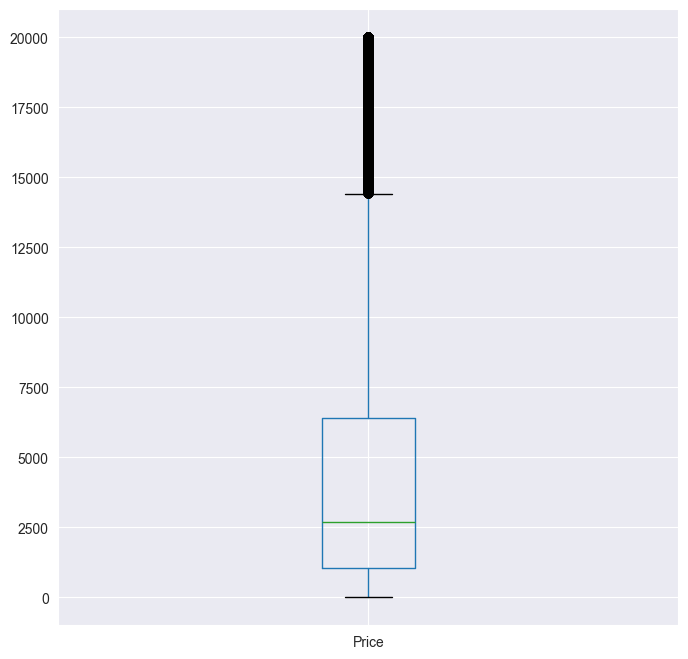

In [18]:
df.boxplot(column=['Price'], figsize=(8,8))
plt.show()

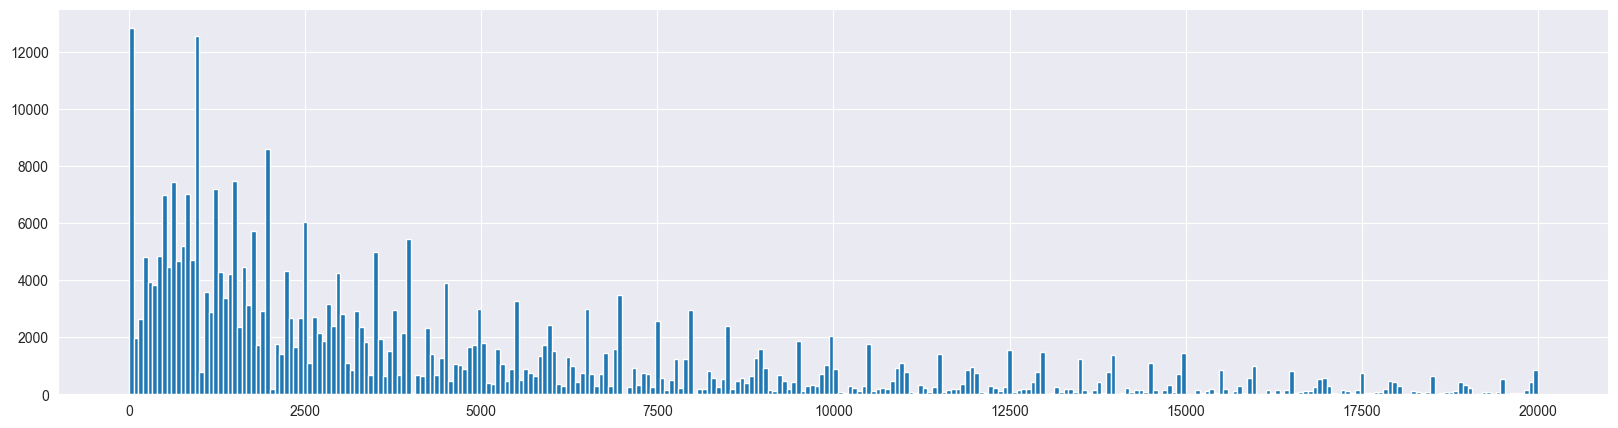

In [19]:
df['Price'].hist(bins=300, figsize=(20,5))
plt.show()

In [20]:
df['Price'].value_counts()

Price
0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: count, Length: 3731, dtype: int64

In [21]:
# посчитаем, какой процент от всего датасета занимают строки, где цена автомобиля указана как 0:
print('{:.2f}'.format(df[df['Price'] == 0].shape[0]/df.shape[0]*100))

3.04


In [22]:
# посчитаем, какой процент от всего датасета занимают выбросы:
print('{:.2f}'.format(df[df['Price'] > 14800].shape[0]/df.shape[0]*100))

4.83


In [23]:
# посмотрим на автомобили, чья цена выше 14800:
df[df['Price'] > 14800]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25 00:00:00,0,39179,2016-04-07 04:45:21
64,2016-03-07 22:36:54,14999,convertible,2007,manual,218,3er,50000,8,petrol,bmw,no,2016-03-07 00:00:00,0,1129,2016-03-15 10:17:59
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,0,38350,2016-03-12 20:18:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354259,2016-03-22 15:53:41,15000,sedan,2013,auto,115,focus,60000,10,gasoline,ford,no,2016-03-22 00:00:00,0,24340,2016-03-31 13:47:54
354279,2016-03-11 11:59:21,16500,suv,2013,manual,116,i_reihe,30000,9,gasoline,hyundai,no,2016-03-11 00:00:00,0,76297,2016-04-07 06:16:09
354286,2016-03-21 20:44:38,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes,2016-03-21 00:00:00,0,74722,2016-04-06 19:16:32
354306,2016-04-02 23:25:40,16999,wagon,2008,auto,269,a6,150000,7,gasoline,audi,no,2016-04-02 00:00:00,0,61440,2016-04-06 15:17:04


In [24]:
# удалим строки датасета, в которых цена автомобиля указана как 0:
df = df[df['Price'] > 0]

#### Признак RegistrationYear

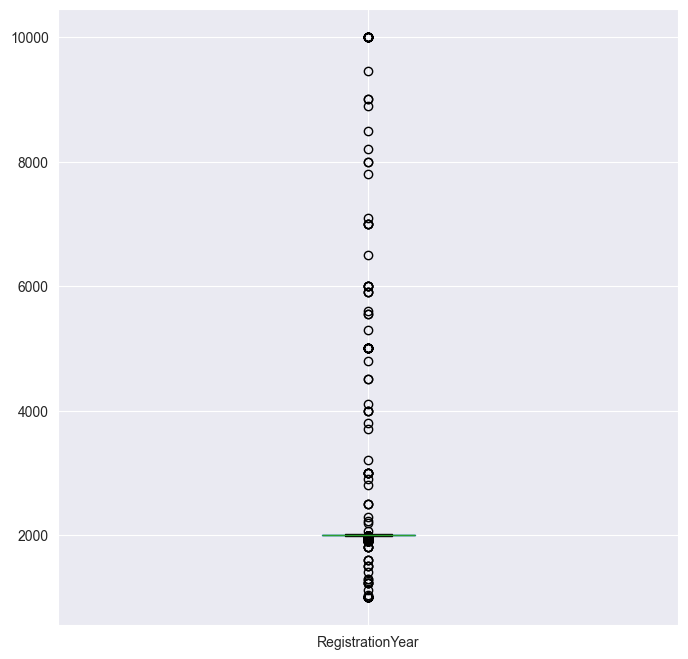

In [25]:
df.boxplot(column=['RegistrationYear'], figsize=(8,8))
plt.show()

In [26]:
# найдем уникальные значения в столбце RegistrationYear и выполним сортировку по индексу:
df['RegistrationYear'].value_counts().sort_index()

RegistrationYear
1000    31
1001     1
1039     1
1111     1
1234     4
        ..
8500     1
8888     1
9000     2
9450     1
9999    18
Name: count, Length: 140, dtype: int64

In [27]:
# проверим даты скачивания анкет из базы:
print(df['DateCrawled'].min())
print(df['DateCrawled'].max())

2016-03-05 14:06:22
2016-04-07 14:36:58


Поскольку наши данные на 2016 год, заменим все значения с годом после 2016 на 2016, и, поскольку автомобили до 1930 года - это скорее всего аномалии, заменим их тоже.

In [28]:
# обработаем выбросы в столбце RegistrationYear: 
def balance_reg_year(value):
    if value > 2016:
        return 2016
    elif value < 1930:
        return 1930
    else:
        return value

df["RegistrationYear"] = df["RegistrationYear"].apply(balance_reg_year)

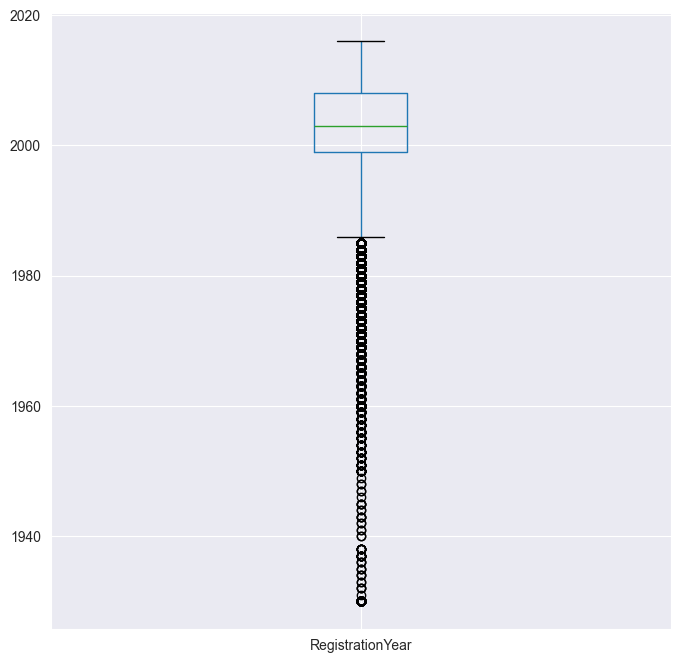

In [29]:
df.boxplot(column=['RegistrationYear'], figsize=(8,8))
plt.show()

#### Признак Power

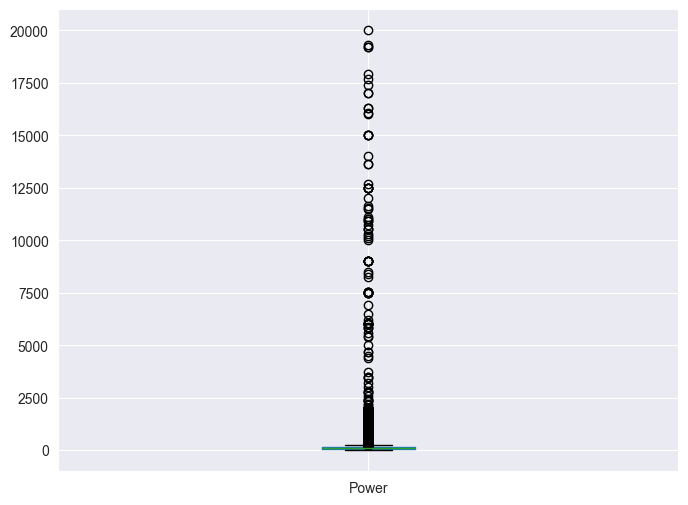

In [30]:
df.boxplot(column=['Power'], figsize=(8,6))
plt.show()

In [31]:
# найдем уникальные значения в столбце Power и выполним сортировку по индексу:
df['Power'].value_counts().sort_index()

Power
0        36360
1           27
2            9
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: count, Length: 701, dtype: int64

In [32]:
# ограничим признак Power 3500 л.с.:
df["Power"] = df["Power"].apply(lambda x: 3500 if x > 3500 else x)

Поскольку иметь 0 л.с. для машины на данный момент нереально, изучим эти данные.

In [33]:
# посчитаем, какой процент от всего датасета занимают строки, где мощность двигателя указана как 0:
print('{:.2f}'.format(df[df['Power'] == 0].shape[0]/df.shape[0]*100))

10.58


In [34]:
# посмотрим на марки автомобилей, мощность которых указана как 0:
df[df['Power'] == 0]['Model'].value_counts()

Model
other         2878
golf          2215
corsa         1629
polo          1471
3er           1384
              ... 
rangerover       1
yeti             1
amarok           1
b_max            1
elefantino       1
Name: count, Length: 244, dtype: int64

In [35]:
# заменим нули на самое частое значение для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        if df[df['Model'] == model]['Power'].value_counts().index[0] == 0:
            new_value = df[df['Model'] == model]['Power'].value_counts().index[1]
            df.loc[(df['Power'] == 0) & (df['Model'] == model), 'Power'] = new_value
        else:
            new_value = df[df['Model'] == model]['Power'].value_counts().index[0]
            df.loc[(df['Power'] == 0) & (df['Model'] == model), 'Power'] = new_value
    except:
        IndexError

In [36]:
# проверим, остались ли нулевые значения и в каком количестве:
print('{:.2f}'.format(df[df['Power'] == 0].shape[0]/df.shape[0]*100))

1.46


In [37]:
# посмотрим на эти данные:
df[df['Power'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
260,2016-04-04 09:49:59,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no,2016-04-04 00:00:00,0,59302,2016-04-06 11:17:11
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
308,2016-03-13 13:38:54,1600,wagon,1999,manual,0,NaN,150000,6,petrol,bmw,no,2016-03-13 00:00:00,0,41199,2016-03-28 12:46:35
361,2016-03-23 23:57:07,300,small,2001,manual,0,NaN,150000,5,petrol,peugeot,yes,2016-03-23 00:00:00,0,84579,2016-03-25 15:22:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354073,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354080,2016-04-03 20:37:39,4300,small,2008,auto,0,NaN,150000,3,NaN,honda,NaN,2016-04-03 00:00:00,0,30627,2016-04-05 21:16:51
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


In [38]:
df.loc[(df['Power'] == 0) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
260,2016-04-04 09:49:59,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no,2016-04-04 00:00:00,0,59302,2016-04-06 11:17:11
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
308,2016-03-13 13:38:54,1600,wagon,1999,manual,0,NaN,150000,6,petrol,bmw,no,2016-03-13 00:00:00,0,41199,2016-03-28 12:46:35
361,2016-03-23 23:57:07,300,small,2001,manual,0,NaN,150000,5,petrol,peugeot,yes,2016-03-23 00:00:00,0,84579,2016-03-25 15:22:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354073,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354080,2016-04-03 20:37:39,4300,small,2008,auto,0,NaN,150000,3,NaN,honda,NaN,2016-04-03 00:00:00,0,30627,2016-04-05 21:16:51
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04


Остается 5028 строк (меньше 1,5% датасета), в которых значения признака Power равны нулю, и во всех этих строках неизвестны модели автомобилей (пропуски). Ограничим мощность двигателей значениями от 10 л.с.:

In [39]:
df = df[df['Power'] > 10]

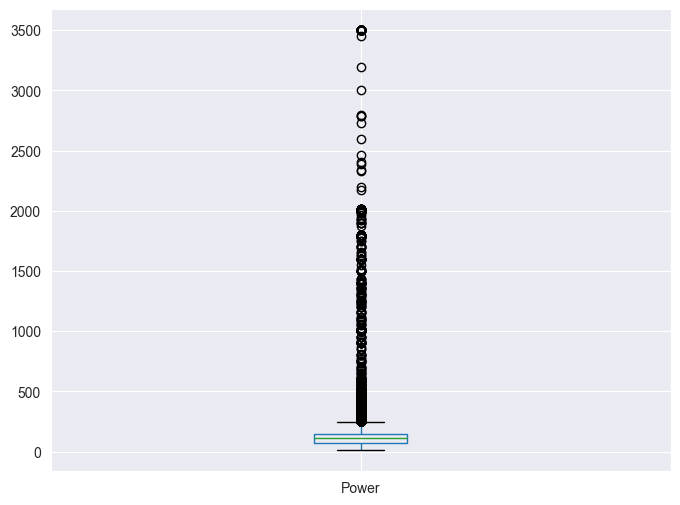

In [40]:
df.boxplot(column=['Power'], figsize=(8,6))
plt.show()

### Обработка пропущенных значений

In [41]:
# процентный список пропущенных данных:
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

DateCrawled - 0.0%
Price - 0.0%
VehicleType - 9.16%
RegistrationYear - 0.0%
Gearbox - 4.45%
Power - 0.0%
Model - 3.65%
Kilometer - 0.0%
RegistrationMonth - 0.0%
FuelType - 7.96%
Brand - 0.0%
Repaired - 18.48%
DateCreated - 0.0%
NumberOfPictures - 0.0%
PostalCode - 0.0%
LastSeen - 0.0%


#### Признак VehicleType

In [42]:
# посмотрим на марки автомобилей с пропусками в признаке VehicleType:
df[df['VehicleType'].isna()]['Model'].value_counts()

Model
golf          3654
other         1643
polo          1452
corsa         1442
3er           1181
              ... 
b_max            1
amarok           1
v60              1
rangerover       1
q3               1
Name: count, Length: 238, dtype: int64

In [43]:
# заполним пропуски самым частым значением для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        veh_type_imp = df[df['Model'] == model]['VehicleType'].value_counts().index[0]
        df.loc[(df['VehicleType'].isna()) & (df['Model'] == model), 'VehicleType'] = veh_type_imp
    except:
        IndexError

In [44]:
# проверим, остались ли пропуски и в каком количестве:
print('{:.2f}'.format(df[df['VehicleType'].isna()].shape[0]/df.shape[0]*100))

0.84


In [45]:
# посмотрим на эти данные:
df[df['VehicleType'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
435,2016-03-27 18:43:25,1300,NaN,2016,manual,150,NaN,150000,10,NaN,volkswagen,no,2016-03-27 00:00:00,0,70374,2016-04-05 15:15:29
762,2016-03-25 15:56:33,1200,NaN,2016,manual,115,NaN,20000,0,petrol,nissan,no,2016-03-25 00:00:00,0,41334,2016-03-25 15:56:33
862,2016-04-02 13:50:51,380,NaN,2016,manual,54,NaN,100000,0,petrol,skoda,yes,2016-04-02 00:00:00,0,3046,2016-04-02 13:50:51
869,2016-03-22 16:57:42,300,NaN,2016,manual,140,NaN,150000,0,petrol,bmw,NaN,2016-03-22 00:00:00,0,57489,2016-03-26 18:18:21
905,2016-03-31 16:36:22,1450,NaN,2016,manual,75,NaN,150000,10,petrol,volkswagen,no,2016-03-31 00:00:00,0,24109,2016-04-06 10:46:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353706,2016-03-24 16:54:28,900,NaN,2016,manual,101,NaN,150000,6,NaN,opel,NaN,2016-03-24 00:00:00,0,50170,2016-04-07 09:17:32
353769,2016-03-25 17:46:19,650,NaN,2000,manual,150,NaN,150000,7,NaN,audi,no,2016-03-25 00:00:00,0,97486,2016-03-27 05:16:34
354007,2016-04-04 21:40:20,10980,NaN,2016,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354011,2016-04-01 02:36:41,1000,NaN,2016,manual,54,NaN,125000,2,NaN,hyundai,no,2016-04-01 00:00:00,0,67547,2016-04-05 02:45:18


In [46]:
df.loc[(df['VehicleType'].isna()) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
435,2016-03-27 18:43:25,1300,NaN,2016,manual,150,NaN,150000,10,NaN,volkswagen,no,2016-03-27 00:00:00,0,70374,2016-04-05 15:15:29
762,2016-03-25 15:56:33,1200,NaN,2016,manual,115,NaN,20000,0,petrol,nissan,no,2016-03-25 00:00:00,0,41334,2016-03-25 15:56:33
862,2016-04-02 13:50:51,380,NaN,2016,manual,54,NaN,100000,0,petrol,skoda,yes,2016-04-02 00:00:00,0,3046,2016-04-02 13:50:51
869,2016-03-22 16:57:42,300,NaN,2016,manual,140,NaN,150000,0,petrol,bmw,NaN,2016-03-22 00:00:00,0,57489,2016-03-26 18:18:21
905,2016-03-31 16:36:22,1450,NaN,2016,manual,75,NaN,150000,10,petrol,volkswagen,no,2016-03-31 00:00:00,0,24109,2016-04-06 10:46:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353706,2016-03-24 16:54:28,900,NaN,2016,manual,101,NaN,150000,6,NaN,opel,NaN,2016-03-24 00:00:00,0,50170,2016-04-07 09:17:32
353769,2016-03-25 17:46:19,650,NaN,2000,manual,150,NaN,150000,7,NaN,audi,no,2016-03-25 00:00:00,0,97486,2016-03-27 05:16:34
354007,2016-04-04 21:40:20,10980,NaN,2016,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354011,2016-04-01 02:36:41,1000,NaN,2016,manual,54,NaN,125000,2,NaN,hyundai,no,2016-04-01 00:00:00,0,67547,2016-04-05 02:45:18


Остается 2836 строк (меньше 1% датасета), в которых остались пропуски в признаке VehicleType, и во всех этих строках неизвестны модели автомобилей (пропуски).

#### Признак Gearbox

In [47]:
# посмотрим на марки автомобилей с пропусками в признаке Gearbox:
df[df['Gearbox'].isna()]['Model'].value_counts()

Model
golf         1317
other        1224
fortwo        781
corsa         697
polo          645
             ... 
yeti            1
i3              1
crossfire       1
200             1
s_type          1
Name: count, Length: 233, dtype: int64

In [48]:
# заполним пропуски самым частым значением для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        gearbox_imp = df[df['Model'] == model]['Gearbox'].value_counts().index[0]
        df.loc[(df['Gearbox'].isna()) & (df['Model'] == model), 'Gearbox'] = gearbox_imp
    except:
        IndexError

In [49]:
# проверим, остались ли пропуски и в каком количестве:
print('{:.2f}'.format(df[df['Gearbox'].isna()].shape[0]/df.shape[0]*100))

0.24


In [50]:
df[df['Gearbox'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
161,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28 00:00:00,0,99086,2016-04-04 11:45:46
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12 00:00:00,0,95131,2016-04-07 14:56:12
1331,2016-04-03 19:53:44,650,NaN,1970,NaN,26,NaN,100000,5,NaN,trabant,NaN,2016-04-03 00:00:00,0,9337,2016-04-05 20:45:24
1345,2016-03-21 01:57:37,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,85057,2016-03-27 21:44:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351442,2016-03-11 08:55:34,20,NaN,1970,NaN,55,NaN,150000,8,NaN,opel,NaN,2016-03-11 00:00:00,0,59872,2016-04-06 11:45:55
351669,2016-03-15 15:48:26,2499,sedan,2001,NaN,180,NaN,150000,0,NaN,audi,NaN,2016-03-15 00:00:00,0,53639,2016-03-21 13:16:02
352626,2016-03-28 11:06:23,1850,NaN,2000,NaN,89,NaN,150000,7,NaN,fiat,NaN,2016-03-28 00:00:00,0,56182,2016-03-28 11:06:23
353104,2016-03-05 23:54:33,1200,NaN,2000,NaN,75,NaN,150000,0,NaN,volkswagen,NaN,2016-03-05 00:00:00,0,86561,2016-03-08 20:48:55


In [51]:
df.loc[(df['Gearbox'].isna()) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
161,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28 00:00:00,0,99086,2016-04-04 11:45:46
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12 00:00:00,0,95131,2016-04-07 14:56:12
1331,2016-04-03 19:53:44,650,NaN,1970,NaN,26,NaN,100000,5,NaN,trabant,NaN,2016-04-03 00:00:00,0,9337,2016-04-05 20:45:24
1345,2016-03-21 01:57:37,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,85057,2016-03-27 21:44:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351442,2016-03-11 08:55:34,20,NaN,1970,NaN,55,NaN,150000,8,NaN,opel,NaN,2016-03-11 00:00:00,0,59872,2016-04-06 11:45:55
351669,2016-03-15 15:48:26,2499,sedan,2001,NaN,180,NaN,150000,0,NaN,audi,NaN,2016-03-15 00:00:00,0,53639,2016-03-21 13:16:02
352626,2016-03-28 11:06:23,1850,NaN,2000,NaN,89,NaN,150000,7,NaN,fiat,NaN,2016-03-28 00:00:00,0,56182,2016-03-28 11:06:23
353104,2016-03-05 23:54:33,1200,NaN,2000,NaN,75,NaN,150000,0,NaN,volkswagen,NaN,2016-03-05 00:00:00,0,86561,2016-03-08 20:48:55


Остается 807 строк (0,24% датасета), в которых остались пропуски в признаке Gearbox, и во всех этих строках неизвестны модели автомобилей (пропуски).

#### Признак FuelType

In [52]:
# посмотрим на марки автомобилей с пропусками в признаке FuelType:
df[df['FuelType'].isna()]['Model'].value_counts()

Model
golf      2187
other     1737
polo      1195
3er       1194
corsa     1191
          ... 
200          1
citigo       1
v60          1
i3           1
9000         1
Name: count, Length: 233, dtype: int64

In [53]:
# заполним пропуски самым частым значением для разных моделей автомобилей:
for model in df['Model'].unique():
    try:
        fuel_type_imp = df[df['Model'] == model]['FuelType'].value_counts().index[0]
        df.loc[(df['FuelType'].isna()) & (df['Model'] == model), 'FuelType'] = fuel_type_imp
    except:
        IndexError

In [54]:
# проверим, остались ли пропуски и в каком количестве:
print('{:.2f}'.format(df[df['FuelType'].isna()].shape[0]/df.shape[0]*100))

1.00


In [55]:
df.loc[(df['FuelType'].isna()) & df['Model'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12 00:00:00,0,95131,2016-04-07 14:56:12
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29 00:00:00,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353769,2016-03-25 17:46:19,650,NaN,2000,manual,150,NaN,150000,7,NaN,audi,no,2016-03-25 00:00:00,0,97486,2016-03-27 05:16:34
353816,2016-03-09 13:37:36,9800,small,2013,manual,90,NaN,50000,4,NaN,renault,NaN,2016-03-09 00:00:00,0,38855,2016-03-14 20:45:05
354007,2016-04-04 21:40:20,10980,NaN,2016,manual,75,NaN,20000,1,NaN,volkswagen,no,2016-04-04 00:00:00,0,44801,2016-04-07 00:15:36
354011,2016-04-01 02:36:41,1000,NaN,2016,manual,54,NaN,125000,2,NaN,hyundai,no,2016-04-01 00:00:00,0,67547,2016-04-05 02:45:18


Остается 3376 строк (1% датасета), в которых остались пропуски в признаке FuelType, и во всех этих строках неизвестны модели автомобилей (пропуски).

Заполним пропуски у признаков Model и Repaired в дальнейшем при создании пайплайна значением unknown, добавив логический параметр add_indicator=True.

In [56]:
# удалим неинформативные признаки:
df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338343 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             338343 non-null  int64 
 1   VehicleType       335507 non-null  object
 2   RegistrationYear  338343 non-null  int64 
 3   Gearbox           337536 non-null  object
 4   Power             338343 non-null  int64 
 5   Model             326006 non-null  object
 6   Kilometer         338343 non-null  int64 
 7   FuelType          334967 non-null  object
 8   Brand             338343 non-null  object
 9   Repaired          275801 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.4+ MB


In [58]:
df.isna().sum()

Price                   0
VehicleType          2836
RegistrationYear        0
Gearbox               807
Power                   0
Model               12337
Kilometer               0
FuelType             3376
Brand                   0
Repaired            62542
dtype: int64

In [59]:
# процентный список пропущенных данных:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Price - 0.0%
VehicleType - 0.84%
RegistrationYear - 0.0%
Gearbox - 0.24%
Power - 0.0%
Model - 3.65%
Kilometer - 0.0%
FuelType - 1.0%
Brand - 0.0%
Repaired - 18.48%


Исследуем признаки на мультиколлинеарность.

In [60]:
# построим 𝜙k correlation matrix:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.00,0.27,0.56,0.33,0.11,0.58,0.31,0.26,0.37,0.37
VehicleType,0.27,1.00,0.15,0.28,0.04,0.92,0.17,0.33,0.63,0.08
RegistrationYear,0.56,0.15,1.00,0.09,0.08,0.58,0.33,0.21,0.37,0.16
Gearbox,0.33,0.28,0.09,1.00,0.09,0.66,0.02,0.15,0.53,0.04
Power,0.11,0.04,0.08,0.09,1.00,0.23,0.02,0.03,0.11,0.01
Model,0.58,0.92,0.58,0.66,0.23,1.00,0.44,0.56,1.00,0.15
Kilometer,0.31,0.17,0.33,0.02,0.02,0.44,1.00,0.14,0.27,0.11
FuelType,0.26,0.33,0.21,0.15,0.03,0.56,0.14,1.00,0.32,0.04
Brand,0.37,0.63,0.37,0.53,0.11,1.00,0.27,0.32,1.00,0.10
Repaired,0.37,0.08,0.16,0.04,0.01,0.15,0.11,0.04,0.10,1.00


In [61]:
# посмотрим, с какими признаками сильнее всего коррелирует/связан целевой атрибут:
phik_target = phik_overview['Price'].sort_values(ascending=False).iloc[1:]
phik_target.round(2)

Model               0.58
RegistrationYear    0.56
Repaired            0.37
Brand               0.37
Gearbox             0.33
Kilometer           0.31
VehicleType         0.27
FuelType            0.26
Power               0.11
Name: Price, dtype: float64

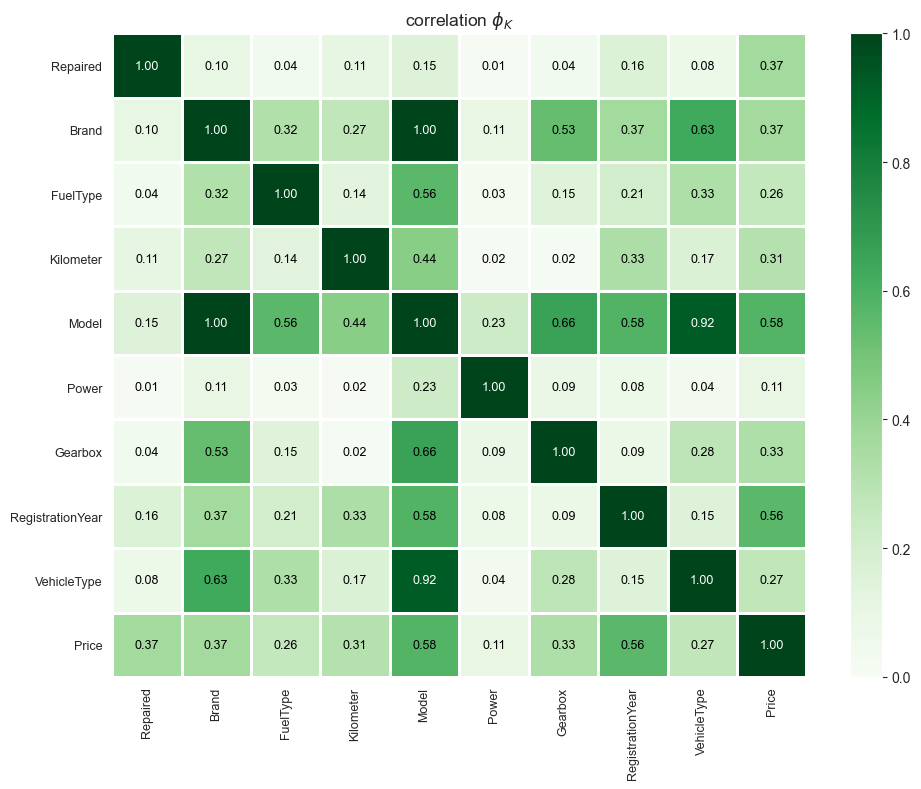

In [62]:
# построим plot_correlation_matrix:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9,
                        figsize=(10, 8))
plt.tight_layout()
plt.show()

## Разделение на выборки

In [63]:
X = df.drop(['Price'], axis = 1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [64]:
# посмотрим на размеры выборок:
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (226689, 9)
Размер тестовой выборки: (111654, 9)


In [65]:
# внесем в переменные списки все численные и категориальные признаки:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

In [66]:
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [67]:
numeric_features

['RegistrationYear', 'Power', 'Kilometer']

# Обучение моделей
## LinearRegression	

In [68]:
cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='unknown', add_indicator=True)),
    ('enc', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())  
])

preprocessor = ColumnTransformer([   
    ("cat", cat_pipeline, categorical_features),    
    ("num", num_pipeline, numeric_features)

])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression()) 
])

In [69]:
score_lr = ((cross_val_score(pipe_lr, 
                             X_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error') * -1) ** 0.5).mean()

In [70]:
print('Среднее качество LinearRegression на кросс-валидации =', round(score_lr, 2))

Среднее качество LinearRegression на кросс-валидации = 2725.12


## LGBMRegressor	

In [77]:
cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', 
                          fill_value='unknown', 
                          add_indicator=True)),
    ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=-1))
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
])

In [78]:
def optuna_optimize(trial):
    param = {
        # 'num_iterations': trial.suggest_int('num_iterations', 50, 900),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'max_bin': trial.suggest_int('max_bin', 100, 255),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 30),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.0, 1.0)      
    }
    
    estimator = LGBMRegressor(**param, 
                              num_iterations=900,
                              verbosity=-1, 
                              random_state=42,
                              categorical_feature=[0,1,2,3,4,5,6,7,8,9,10])

    pipe_lgbm = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    score = ((cross_val_score(pipe_lgbm, 
                              X_train, 
                              y_train, 
                              cv=5, 
                              scoring='neg_mean_squared_error') * -1) ** 0.5).mean()
    return score

In [79]:
study_lightgbm = optuna.create_study(study_name="LightGBM Optuna Optimization",
                                   direction='minimize')

[I 2024-01-22 18:25:09,921] A new study created in memory with name: LightGBM Optuna Optimization


In [80]:
study_lightgbm.optimize(optuna_optimize, n_trials=200)

[I 2024-01-22 18:25:23,375] Trial 0 finished with value: 1667.1779703432846 and parameters: {'max_depth': 11, 'max_bin': 172, 'learning_rate': 0.45022971937563294, 'num_leaves': 51, 'min_data_in_leaf': 9, 'lambda_l1': 0.00500141649679663, 'min_child_weight': 4.099644794827042, 'feature_fraction': 0.8237998097900643, 'bagging_fraction': 0.19910345502439264}. Best is trial 0 with value: 1667.1779703432846.
[I 2024-01-22 18:25:33,993] Trial 1 finished with value: 1756.443466609549 and parameters: {'max_depth': 4, 'max_bin': 165, 'learning_rate': 0.4952593342387699, 'num_leaves': 46, 'min_data_in_leaf': 23, 'lambda_l1': 0.01307948107373762, 'min_child_weight': 1.1806038600518383, 'feature_fraction': 0.11544328498758427, 'bagging_fraction': 0.7679757881276503}. Best is trial 0 with value: 1667.1779703432846.
[I 2024-01-22 18:25:44,866] Trial 2 finished with value: 1731.4126777581391 and parameters: {'max_depth': 4, 'max_bin': 121, 'learning_rate': 0.9100495408587812, 'num_leaves': 107, 'min

In [80]:
print("Наилучшие значения гиперпараметров LightGBM: {}".format(study_lightgbm.best_params))
print()
print("Среднее качество LightGBM на кросс-валидации = {:.2f}". format(study_lightgbm.best_value))

Наилучшие значения гиперпараметров LightGBM: {'max_depth': 20, 'max_bin': 144, 'learning_rate': 0.06247874601977893, 'num_leaves': 128, 'min_data_in_leaf': 6, 'lambda_l1': 0.0925516387531472, 'min_child_weight': 2.914257784641623, 'feature_fraction': 0.8915971412187355, 'bagging_fraction': 0.4144314250461005}

Среднее качество LightGBM на кросс-валидации = 1590.43


In [81]:
with mlflow.start_run(nested=True,
                      run_name='lgbm_pipeline'):

    best_params = study_lightgbm.best_params
    best_score = study_lightgbm.best_value
    mlflow.log_params(best_params)

    pipe_lgbm = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(**best_params,
                                num_iterations=900,
                                verbosity=-1,
                                random_state=42,
                                categorical_feature=[0,1,2,3,4,5,6,7,8,9,10]))
    ])

    pipe_lgbm.fit(X_train, y_train)

    mlflow.log_metric('RMSE', best_score)

    mlflow.sklearn.log_model(pipe_lgbm, 'lgbm_pipeline')

## CatBoostRegressor	

In [84]:
cat_features=['cat__VehicleType',
              'cat__Gearbox',
              'cat__Model',
              'cat__FuelType',
              'cat__Brand',
              'cat__Repaired',
              'cat__missingindicator_VehicleType',
              'cat__missingindicator_Gearbox',
              'cat__missingindicator_Model',
              'cat__missingindicator_FuelType',
              'cat__missingindicator_Repaired']

In [100]:
cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='unknown', add_indicator=True))
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
])

In [73]:
def optuna_optimize(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 1, 16),
        # 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 5.0) 
    }

    estimator = CatBoostRegressor(**param,
                              subsample=1,                        
                              boosting_type='Plain',
                              bootstrap_type='Poisson',
                              random_state=42,
                              verbose=False,
                              cat_features=cat_features,
                              iterations=900,
                              task_type="GPU")
    
    pipe_cat = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = ((cross_val_score(pipe_cat, X_train, y_train, cv=5, scoring='neg_mean_squared_error', error_score='raise') * -1) ** 0.5).mean()

    return score

In [74]:
study_cat = optuna.create_study(study_name="CatBoost Optuna Optimization",
                                direction='minimize')

[I 2024-01-21 23:24:14,653] A new study created in memory with name: CatBoost Optuna Optimization


In [75]:
study_cat.optimize(optuna_optimize, n_trials=200)

[I 2024-01-21 23:28:09,319] Trial 0 finished with value: 4238.305740758727 and parameters: {'learning_rate': 0.026005871415838794, 'depth': 14, 'subsample': 0.5078930848051694, 'min_data_in_leaf': 60, 'l2_leaf_reg': 1.2230870235546576}. Best is trial 0 with value: 4238.305740758727.
[I 2024-01-21 23:38:32,778] Trial 1 finished with value: 1671.3405734662192 and parameters: {'learning_rate': 0.011970129682665878, 'depth': 14, 'subsample': 0.8558668734595345, 'min_data_in_leaf': 55, 'l2_leaf_reg': 2.305947368021063}. Best is trial 1 with value: 1671.3405734662192.
[I 2024-01-21 23:39:31,544] Trial 2 finished with value: 4282.867235175801 and parameters: {'learning_rate': 0.010239900152113578, 'depth': 5, 'subsample': 0.20288210724065892, 'min_data_in_leaf': 34, 'l2_leaf_reg': 3.8067686333372657}. Best is trial 1 with value: 1671.3405734662192.
[I 2024-01-21 23:41:05,324] Trial 3 finished with value: 1676.692578637317 and parameters: {'learning_rate': 0.09886297213983117, 'depth': 7, 'sub

In [76]:
print("Наилучшие значения гиперпараметров CatBoost: {}".format(study_cat.best_params))
print()
print("Среднее качество CatBoost на кросс-валидации = {:.2f}". format(study_cat.best_value))

Наилучшие значения гиперпараметров CatBoost: {'learning_rate': 0.08885667121982167, 'depth': 12, 'subsample': 0.9977454670385691, 'min_data_in_leaf': 77, 'l2_leaf_reg': 1.467901507389107}

Среднее качество CatBoost на кросс-валидации = 1617.30


In [101]:
with mlflow.start_run(nested=True,
                      run_name='catboost_pipeline'):

    best_params = study_cat.best_params
    best_score = study_cat.best_value
    mlflow.log_params(best_params)

    pipe_cat = Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(**best_params,
                                    boosting_type='Plain',
                                    bootstrap_type='Poisson',
                                    random_state=42,
                                    verbose=False,
                                    cat_features=cat_features,
                                    iterations=900,
                                    task_type="GPU"))
    ])

    pipe_cat.fit(X_train, y_train)

    mlflow.log_metric('RMSE', best_score)

    mlflow.sklearn.log_model(pipe_cat, 'catboost_pipeline')

# Тестирование лучшей модели
## LGBMRegressor

In [87]:
lgbm = mlflow.sklearn.load_model('runs:/09d269f374a34497bf70ba3506f4cd72/lgbm_pipeline')

In [88]:
lgbm_pred = lgbm.predict(X_test)

In [89]:
lgbm_rmse = round(mean_squared_error(y_test, lgbm_pred, squared=False), 2)
lgbm_mape = round(mean_absolute_percentage_error(y_test, lgbm_pred), 2)
lgbm_r2 = round(r2_score(y_test, lgbm_pred), 2)
lgbm_mae = round(mean_absolute_error(y_test, lgbm_pred), 2)

In [90]:
print('RMSE of LGBMRegressor =', lgbm_rmse)
print('MAPE of LGBMRegressor =', lgbm_mape)
print('R2 of LGBMRegressor =', lgbm_r2)
print('MAE of LGBMRegressor =', lgbm_mae)

RMSE of LGBMRegressor = 1558.53
MAPE of LGBMRegressor = 8.65
R2 of LGBMRegressor = 0.88
MAE of LGBMRegressor = 961.22


## CatBoostRegressor

In [101]:
catboost = mlflow.sklearn.load_model('runs:/96761e30f3774d5b99d5ca02e319fabf/catboost_pipeline')

In [102]:
catboost_pred = catboost.predict(X_test)

In [130]:
catboost_rmse = round(mean_squared_error(y_test, catboost_pred, squared=False), 2)
catboost_mape = round(mean_absolute_percentage_error(y_test, catboost_pred), 2)
catboost_r2 = round(r2_score(y_test, catboost_pred), 2)
catboost_mae = round(mean_absolute_error(y_test, catboost_pred), 2)

In [131]:
print('RMSE of CatBoostRegressor =', catboost_rmse)
print('MAPE of CatBoostRegressor =', catboost_mape)
print('R2 of CatBoostRegressor =', catboost_r2)
print('MAE of CatBoostRegressor =', catboost_mae)

RMSE of CatBoostRegressor = 1660.59
MAPE of CatBoostRegressor = 9.01
R2 of CatBoostRegressor = 0.87
MAE of CatBoostRegressor = 1030.85


In [132]:
colNames = ["LGBMRegressor", "CatBoostRegressor"]
results = {"RMSE":[lgbm_rmse,
                   catboost_rmse],
           "MAPE":[lgbm_mape,
                   catboost_mape],
           "R2": [lgbm_r2,
                  catboost_r2],
           "MAE": [lgbm_mae,
                   catboost_mae]}

In [133]:
table = pd.DataFrame.from_dict(results, orient='index', columns=colNames)

In [134]:
table

,LGBMRegressor,CatBoostRegressor
RMSE,1597.65,1660.59
MAPE,8.82,9.01
R2,0.88,0.87
MAE,992.06,1030.85


In [152]:
pd.DataFrame(y_test)

,Price
288379,6700
84343,3480
162646,799
67030,10900
147798,700
...,...
105652,1000
271099,5900
117033,4600
246987,15499


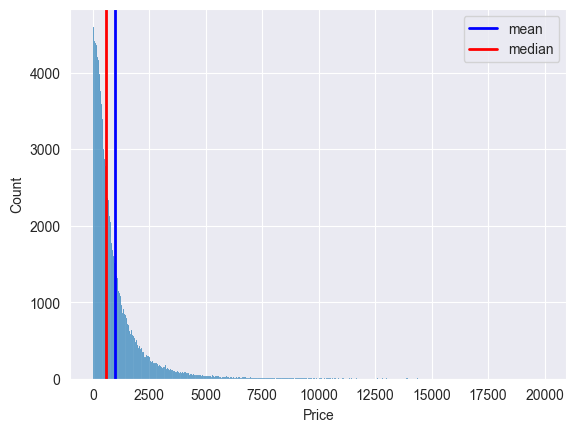

In [91]:
# (abs(lgbm_pred-y_test)).hist(bins=100)
residuals = abs(lgbm_pred-y_test)
sns.histplot(data=residuals)
plt.axvline(residuals.mean(), color='b', lw=2, label='mean')
plt.axvline(residuals.median(), color='r', lw=2, label='median')
plt.legend()
plt.show()

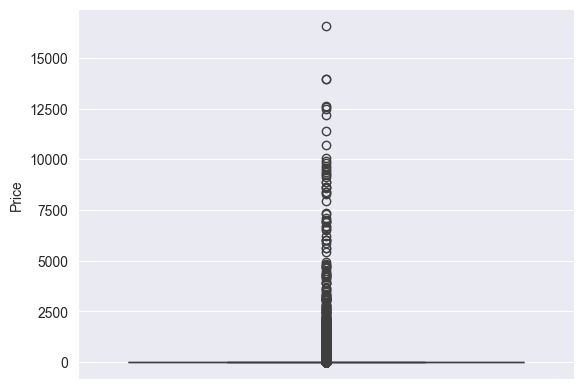

In [92]:
sns.boxplot((abs(lgbm_pred-y_test)/y_test))
plt.show()

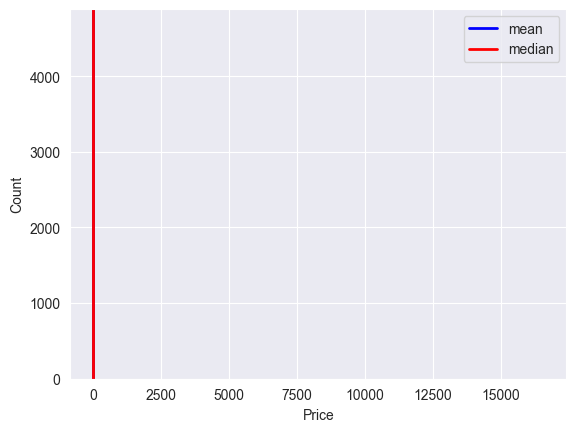

In [93]:
relative_residuals = residuals / y_test
sns.histplot(data=relative_residuals)
plt.axvline(relative_residuals.mean(), color='b', lw=2, label='mean')
plt.axvline(relative_residuals.median(), color='r', lw=2, label='median')
plt.legend()
plt.show()

In [76]:
df2

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [7]:
df2.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

In [8]:
df2

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [9]:
df2 = df2[df2['Power'] > 10]

In [10]:
df2

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [11]:
df2 = df2[df2['Price'] > 0]

In [12]:
df2

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [13]:
df2["RegistrationYear"] = df2["RegistrationYear"].apply(balance_reg_year)

NameError: name 'balance_reg_year' is not defined

In [ ]:
df2["Power"] = df2["Power"].apply(lambda x: 3500 if x > 3500 else x)

In [ ]:
X = df2.drop(['Price'], axis = 1)
y = df2['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

In [104]:
cat_pipeline = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('imp', IterativeImputer(missing_values=-1, initial_strategy='most_frequent', random_state=42, add_indicator=True))
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer()),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [105]:
score_lr = ((cross_val_score(pipe_lr,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='neg_mean_squared_error',
                             error_score='raise') * -1) ** 0.5).mean()

In [106]:
score_lr

2576.4851328121767

In [139]:
cat_pipeline = Pipeline([
    ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=-1,
                           encoded_missing_value=-2)), # чтобы не было нанов, импьютер выдает ошибку
    ('imp', IterativeImputer(missing_values=-1, 
                             initial_strategy='most_frequent', 
                             random_state=42, 
                             add_indicator=True))
])

num_pipeline = Pipeline([
    ('pt', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numeric_features)
])

In [140]:
def optuna_optimize(trial):
    param = {
        # 'num_iterations': trial.suggest_int('num_iterations', 50, 900),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'max_bin': trial.suggest_int('max_bin', 100, 255),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 30),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.0, 1.0)
    }

    estimator = LGBMRegressor(**param,
                              num_iterations=900,
                              verbosity=-1,
                              random_state=42,
                              categorical_feature=[0,1,2,3,4,5,6,7,8,9,10]) # проверить!!!!

    pipe_lgbm = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = ((cross_val_score(pipe_lgbm,
                              X_train,
                              y_train,
                              cv=5,
                              scoring='neg_mean_squared_error') * -1) ** 0.5).mean()
    return score

In [141]:
study_lightgbm = optuna.create_study(study_name="LightGBM Optuna Optimization",
                                     direction='minimize')

[I 2023-12-27 15:01:53,611] A new study created in memory with name: LightGBM Optuna Optimization


In [142]:
study_lightgbm.optimize(optuna_optimize, n_trials=200)

[I 2023-12-27 15:03:47,926] Trial 0 finished with value: 2385.103028873406 and parameters: {'max_depth': 17, 'max_bin': 106, 'learning_rate': 0.14230891126791773, 'num_leaves': 67, 'min_data_in_leaf': 14, 'lambda_l1': 0.014453364480064346, 'min_child_weight': 0.4412156185877958, 'feature_fraction': 0.44369093798237713, 'bagging_fraction': 0.7561498451361868}. Best is trial 0 with value: 2385.103028873406.
[I 2023-12-27 15:04:51,583] Trial 1 finished with value: 2524.1645662491437 and parameters: {'max_depth': 20, 'max_bin': 251, 'learning_rate': 0.3093668445625605, 'num_leaves': 45, 'min_data_in_leaf': 7, 'lambda_l1': 0.060094864558952514, 'min_child_weight': 4.56581249037459, 'feature_fraction': 0.19712293181680374, 'bagging_fraction': 0.6939534924362909}. Best is trial 0 with value: 2385.103028873406.
[I 2023-12-27 15:06:44,247] Trial 2 finished with value: 2366.164155550474 and parameters: {'max_depth': 14, 'max_bin': 113, 'learning_rate': 0.17706176165720808, 'num_leaves': 98, 'min

KeyboardInterrupt: 